In [42]:
import timeit
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from collections import Counter
from glob import glob
from unicodedata import normalize
import unidecode
from termcolor import colored
import joblib
from nltk import ngrams
from tqdm.notebook import tqdm

In [2]:
path_name = r'../data/txt_test/*.txt'

In [3]:
tokens_sentences = joblib.load('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/lemmatizers/fall_pass/main_list_tokens_stanza_sentences_chapitres.pkl')
MOTIFS_sentences = joblib.load('/home/crazyjeannot/Documents/doctorat/dev/AWARDS/data/MOTIFS_AWARDS.pkl')
chapitres_index_sentences = joblib.load('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/lemmatizers/fall_pass/main_list_index_stanza_sentences_chapitres.pkl')

In [4]:
best_coefs = pd.read_csv(r'../outputs/BEST_MOTIFS_COEFS.csv', index_col='Unnamed: 0')
best_coefs = best_coefs.T
best_coefs.rename(columns={0: 'coefs'}, inplace=True)
best_coefs.sort_values(by=['coefs'], ascending=False, inplace=True)

In [5]:
non_AWARD = best_coefs[:1000]
AWARD = best_coefs[-1000:]

In [6]:
selected_coefs = pd.concat([non_AWARD, AWARD], axis=0)

In [7]:
def clean_text(txt):
    txt_res = normalize("NFKD", txt).replace('\xa0', ' ')
    txt_res = txt_res.replace("\\", "").replace('\\xa0', '')
    return txt_res

In [8]:
def rolling_group_sentences(sentences, group_size, overlap):
    grouped_sentences = [sentences[i - overlap : i + group_size + overlap] for i in range(overlap, len(sentences) - overlap, group_size)]
    #grouped_sentences = [sentences[i:i + group_size] for i in range(0, len(sentences) - overlap + 1, overlap)]
    return grouped_sentences

In [9]:
def ngram_list(sentences, n_gram_len):
    # Flatten the list of sentences and split into words
    words = [word for sentence in sentences for word in sentence.split()]
    # Generate n-grams
    n_grams = ngrams(words, n_gram_len)
    return n_grams

In [10]:
def generate_n_grams_dico(n):
    dico_list_ngrams = {}
    for i in range(1, n+1):
        list_name = f"list_{i}_gram"
        dico_list_ngrams[list_name]=[]

    return dico_list_ngrams

In [11]:
def get_ngrams(chunk, len_ngrams=5):
    DICT_TEMP = generate_n_grams_dico(len_ngrams)#key = "list_{i}_gram" avec list vide   
    
    for i in range(1, len_ngrams+1):
            DICT_TEMP[f"list_{i}_gram"].extend(ngram_list(chunk, i))# too big for memory ?
            
    return DICT_TEMP

In [12]:
def compute_score(list_chunks, df_coef, len_ngrams):
    list_scores = []
    for chunk in tqdm(list_chunks):
        score = 0
        DICT_NGRAMS = get_ngrams(chunk, len_ngrams)
        
        for i in range(1, len_ngrams+1):
            list_courante = DICT_NGRAMS[f"list_{i}_gram"]
            for ngram in list_courante:
                ngram_str = '_'.join(ngram)
                if ngram_str in list(df_coef.index):
                    temp_score = df_coef.loc[df_coef.index == ngram_str]
                    score += temp_score.values[0][0]
        list_scores.append(score)
    return list_scores

In [13]:
def signal_canon(path_name, list_index, list_motifs, df_coef, group_size, overlap, len_ngrams=5):# 100, 10
    
    df_main = pd.DataFrame()

    for doc in glob(path_name):
        
        doc_name = path.splitext(path.basename(doc))[0]
        print(doc_name)
        if doc_name in list_index:
            index_of_element = list_index.index(doc_name)
            list_chunks = rolling_group_sentences(list_motifs[index_of_element], group_size, overlap)
            list_scores = compute_score(list_chunks, df_coef, len_ngrams)
            print(pd.Series(list_scores).mean())
            df_main[doc_name] = pd.Series(list_scores)
        else:
            pass
    
    return df_main.fillna(0)

In [14]:
def plot_signal(df):
    plt.figure(figsize=(9,6))
    ax = plt.subplot()
    #ax.set_title('Award Signal in our novels')

    ax = sns.lineplot(data=df)

    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = 20)

    ax.set_xlabel('Morceaux roulants des romans')
    ax.set_ylabel('Score')

    plt.savefig('../img/SIGNAL_viz_KESSEL.png', format='png', bbox_inches='tight', dpi=400)

    plt.show()

In [15]:
df_scores = signal_canon(path_name, chapitres_index_sentences, MOTIFS_sentences, selected_coefs, 20, 10)#selected_coefs/best_coefs

2000_Quignard-Pascal_Terrasse-a-Rome


  0%|          | 0/63 [00:00<?, ?it/s]

0.02519579154589147
1968_Yourcenar-Marguerite_L-Oeuvre-Au-Noir


  0%|          | 0/255 [00:00<?, ?it/s]

0.02356179064530718
1958_Kessel-Joseph_Le-lion


  0%|          | 0/187 [00:00<?, ?it/s]

0.14230120720849118


In [61]:
df_scores = signal_canon(path_name, chapitres_index_sentences, MOTIFS_sentences, selected_coefs, 30, 10)

2000_Quignard-Pascal_Terrasse-a-Rome


  0%|          | 0/127 [00:00<?, ?it/s]

-0.03370305187293849
1968_Yourcenar-Marguerite_L-Oeuvre-Au-Noir


  0%|          | 0/511 [00:00<?, ?it/s]

-0.05567353114432507
1958_Kessel-Joseph_Le-lion


  0%|          | 0/374 [00:00<?, ?it/s]

0.044568910154761526


In [37]:
df_scores = signal_canon(path_name, chapitres_index_sentences, MOTIFS_sentences, selected_coefs)

2000_Quignard-Pascal_Terrasse-a-Rome


  0%|          | 0/127 [00:00<?, ?it/s]

-0.1218432177779223
1968_Yourcenar-Marguerite_L-Oeuvre-Au-Noir


  0%|          | 0/511 [00:00<?, ?it/s]

-0.2097199087511508
1958_Kessel-Joseph_Le-lion


  0%|          | 0/374 [00:00<?, ?it/s]

0.03700513477612415


In [32]:
df_test = signal_canon(path_name, chapitres_index_sentences, MOTIFS_sentences, selected_coefs)

1942_Simenon-Georges_Cecile-est-morte


  0%|          | 0/157 [00:00<?, ?it/s]

0.2347254833220573
1904_Rolland-Romain_Jean-Christophe_Tome-I-L-aube


  0%|          | 0/243 [00:00<?, ?it/s]

-0.12985169807933797
1932_Celine-Louis-Ferdinand_Voyage-au-bout-de-la-nuit


  0%|          | 0/804 [00:00<?, ?it/s]

-0.0008856486121822754
1942_Veuzit-Max-du_Moineau-en-cage


  0%|          | 0/367 [00:00<?, ?it/s]

0.21093922602647186


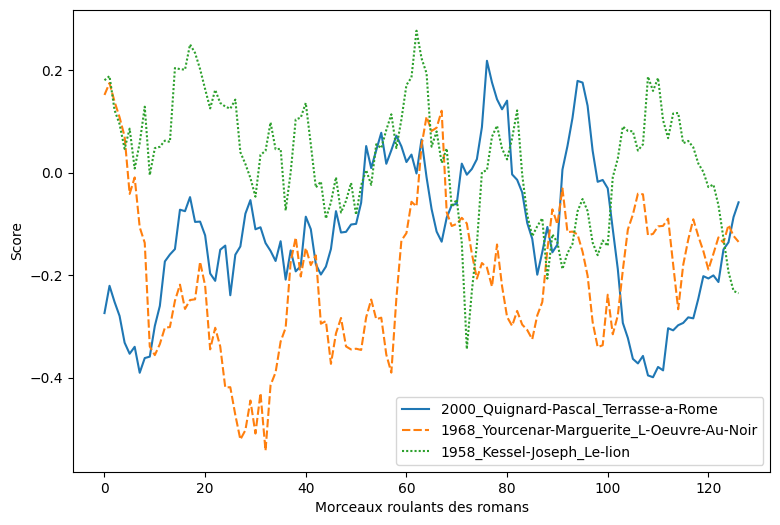

In [38]:
plot_signal(df_scores)

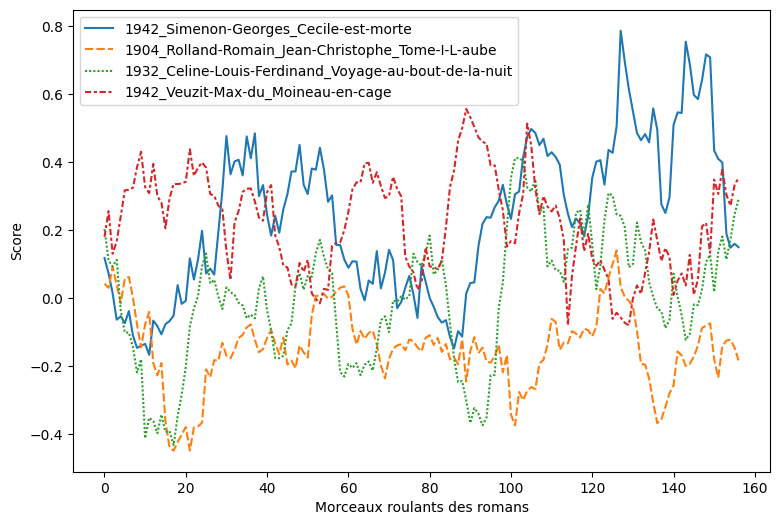

In [35]:
plot_signal(df_test)

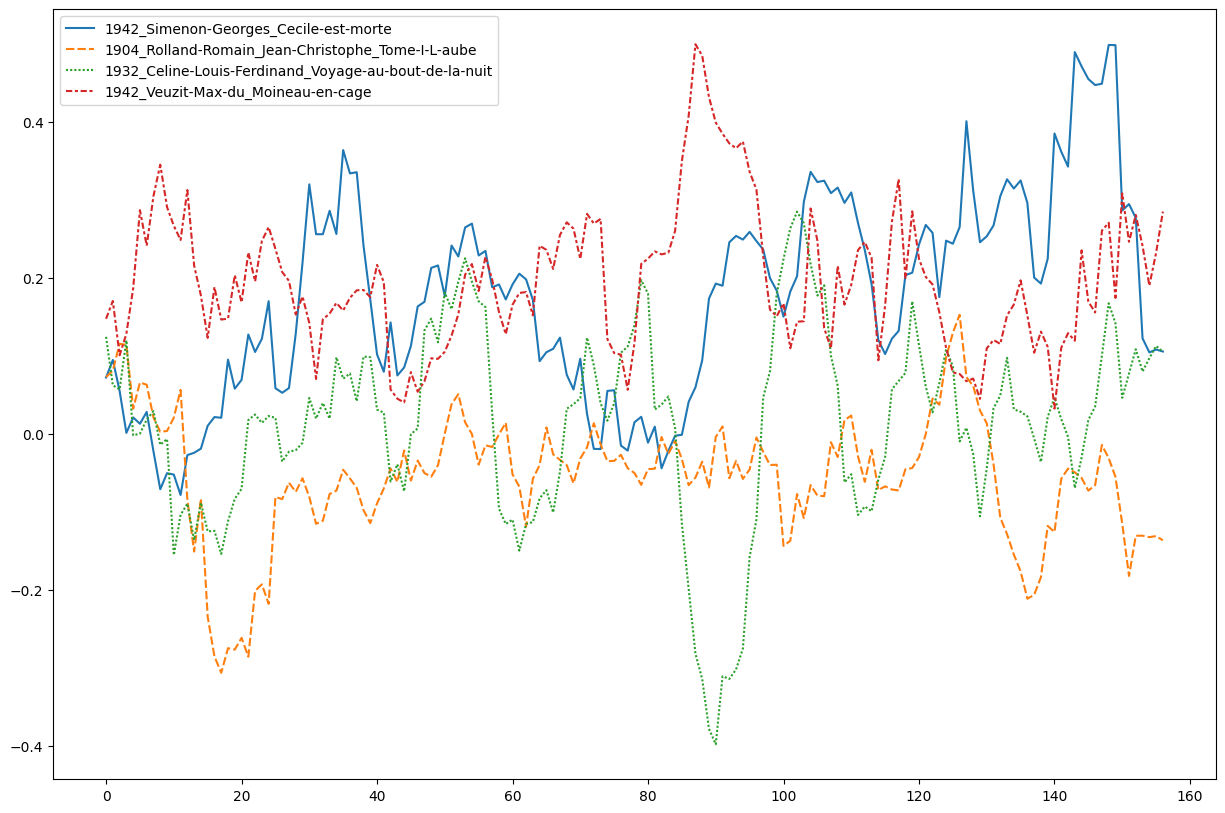

In [27]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=df_scores)

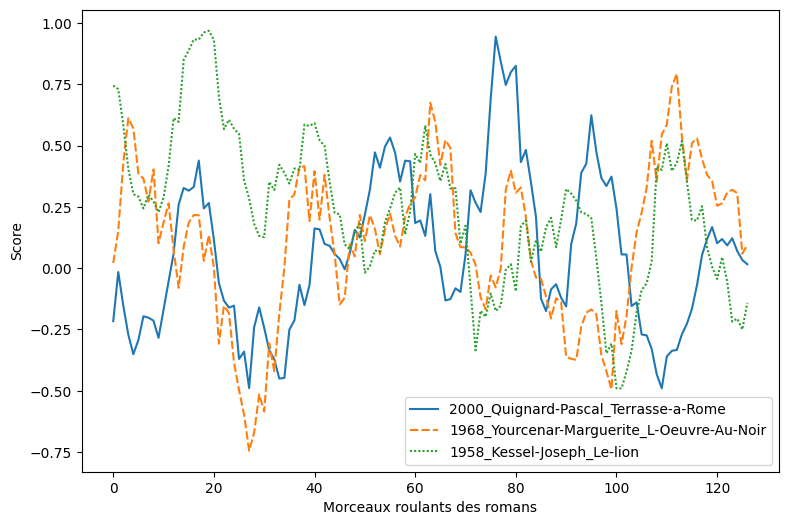

In [17]:
plot_signal(df_scores)

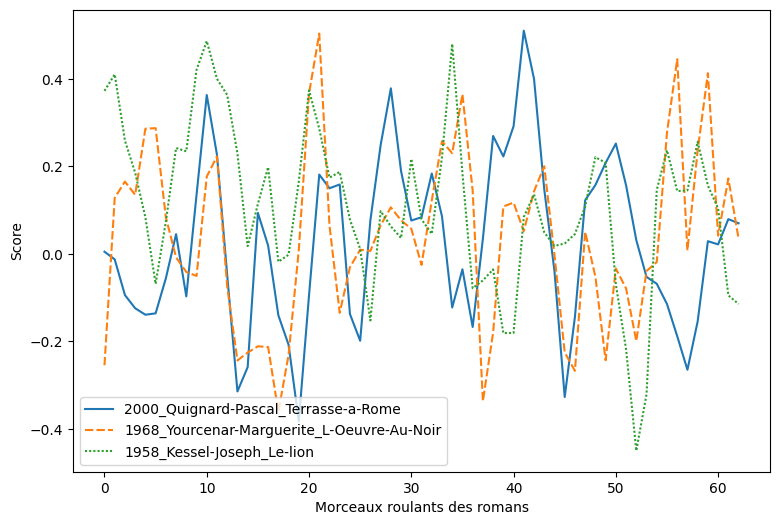

In [16]:
plot_signal(df_scores)

### GET PASSAGES

In [18]:
df_scores['1968_Yourcenar-Marguerite_L-Oeuvre-Au-Noir'][15:20] # Yourcenar Awarded - 27 / 17

15   -0.211371
16   -0.213135
17   -0.361476
18   -0.231180
19    0.008962
Name: 1968_Yourcenar-Marguerite_L-Oeuvre-Au-Noir, dtype: float64

In [20]:
df_scores["1958_Kessel-Joseph_Le-lion"][8:12]# Kessel not-awarded - 19 /10

8     0.234728
9     0.421202
10    0.487130
11    0.400522
Name: 1958_Kessel-Joseph_Le-lion, dtype: float64

In [21]:
df_scores['2000_Quignard-Pascal_Terrasse-a-Rome'][40:45]# Quignard not awarded - 76 / 41

40    0.292118
41    0.510650
42    0.400359
43    0.147746
44   -0.039633
Name: 2000_Quignard-Pascal_Terrasse-a-Rome, dtype: float64

In [24]:
df_scores['2000_Quignard-Pascal_Terrasse-a-Rome'][15:22] # Quignard awarded - 109 /19

15    0.093886
16    0.018918
17   -0.140305
18   -0.207912
19   -0.382864
20   -0.094651
21    0.181556
Name: 2000_Quignard-Pascal_Terrasse-a-Rome, dtype: float64

In [25]:
def rolling_group_sentences(sentences, group_size, overlap):
    #grouped_sentences = [sentences[i:i + group_size] for i in range(0, len(sentences) - overlap + 1, overlap)]
    grouped_sentences = [sentences[i - overlap : i + group_size + overlap] for i in range(overlap, len(sentences) - overlap, group_size)]
    return grouped_sentences

In [29]:
def get_chunk_n(path_txt, list_index, list_motifs, passage_n, group_size=20, overlap=10):
    doc_name = path.splitext(path.basename(path_txt))[0]
    
    if doc_name in list_index:
        index_of_element = list_index.index(doc_name)
        list_chunks = rolling_group_sentences(list_motifs[index_of_element], group_size, overlap)

    else:
        print("not lemmatized")
    return ' '.join(list_chunks[passage_n])

In [30]:
path_txt = r'../data/txt_test/2000_Quignard-Pascal_Terrasse-a-Rome.txt'

In [31]:
quignard_not_awarded = get_chunk_n(path_txt, chapitres_index_sentences, tokens_sentences, 17)

In [32]:
with open('quignard_not_awarded2.txt', 'w') as f:
    f.write(quignard_not_awarded)

In [33]:
quignard_awarded = get_chunk_n(path_txt, chapitres_index_sentences, tokens_sentences, 10)

In [34]:
with open('quignard_awarded2.txt', 'w') as f:
    f.write(quignard_awarded)

In [35]:
path_txt = r'../data/txt_test/1958_Kessel-Joseph_Le-lion.txt'

In [36]:
kessel_not_awarded = get_chunk_n(path_txt, chapitres_index_sentences, tokens_sentences, 41)

In [37]:
with open('kessel_not_awarded2.txt', 'w') as f:
    f.write(kessel_not_awarded)

In [38]:
path_txt = r'../data/txt_test/1968_Yourcenar-Marguerite_L-Oeuvre-Au-Noir.txt'

In [39]:
yourcenar_awarded = get_chunk_n(path_txt, chapitres_index_sentences, tokens_sentences, 19)

In [40]:
with open('yourcenar_awarded2.txt', 'w') as f:
    f.write(yourcenar_awarded)

In [41]:
yourcenar_awarded

'on avait rénové ce logis dans le style à la mode avec des plinthes et des caryatides de pierre de plus en plus le gros ligre se lançait dans ces achats de biens à le soleil qui attestent presque arrogamment la fortune d’ un homme et font de lui en cas de danger le bourgeois de plus d’ une ville en tournaisis il arrondissait pièce à le pièce les terres de sa femme jacqueline près d’ anvers il venait d’ acquérir le domaine de gallifort annexe splendide à son comptoir de la place saint-jacques où il opérait désormais avec grand trésorier des flandres propriétaire d’ une raffinerie de sucre à le maestricht et d’ une autre à les canaries fermier de la douane de zélande détenteur de le monopole de l’ alun pour les régions baltiques assurant pour un tiers avec les fuggers les revenus de l’ ordre de calatrava henri-juste se frottait de plus en plus à les puissants de ce monde la régente à le malines lui offrait de sa main le pain bénit le seigneur de son obligé pour la som

### get motifs

In [43]:
quignard_not_awarded = get_chunk_n(path_txt, chapitres_index_sentences, MOTIFS_sentences, 17)

In [44]:
quignard_not_awarded

'de NOUN de le NOUN le NOUN VERB à le NOUN de un NOUN de NOUN VERB sur le NOUN comme un ADJ NOUN à le NOUN de un NOUN ADJ le NOUN NOUN de NOUN qui VERB de à le NOUN de NOUN VERB comme un NOUN par NOUN sur le NOUN ADJ et VERB dans le NOUN ADJ de le NOUN VERB de un NOUN un NOUN ou un NOUN alors VERB de un ADJ NOUN VERB sur un NOUN VERB le NOUN il VERB le NOUN de NOUN VERB un NOUN de NOUN à le NOUN de le NOUN et de le NOUN de le NOUN à le NOUN de le NOUN de le NOUN de NOUN et un ADJ NOUN de NOUN lui VERB un NOUN le NOUN VERB parmi ce NOUN en NOUN de NOUN ce que le NOUN de NOUN VERB auprès un NOUN et un NOUN de NOUN un NOUN plus ADJ et plus ADJ que le sien parce que il se VERB plus ADJ loin de le NOUN et de le NOUN le NOUN ADJ de NOUN gros- NOUN et de NOUN ADJ le NOUN et le NOUN ADJ un NOUN de NOUN de NOUN et de NOUN aussi ADJ que le NOUN de le ADJ NOUN un NOUN qui ne VERB pas que à se VERB sur un NOUN un NOUN à le NOUN le NOUN VERB VERB de le NOUN et de le NOUN de quoi VERB ou VERB l

In [55]:
def ngram_frequencies_chunk(chunk, n_gram_len, m_most_common):
    # Flatten the list of sentences and split into words
    words = chunk.split()
    # Generate n-gram
    n_grams_all = list(ngrams(words, n_gram_len))
    # filter ngrams
    ngram_counts = Counter(n_grams_all)
    # Calculate relative frequencies
    total_ngrams = sum(ngram_counts.values())
    return {'_'.join(list(ngram)): count / total_ngrams for ngram, count in dict(ngram_counts.most_common(m_most_common)).items()}

In [58]:
chunk_data = {}
m_most_common = 5
# Calculate n-gram frequencies for n=1 to n=len_ngrams
for i in range(1, 6):
    chunk_data.update(ngram_frequencies_chunk(quignard_not_awarded, i, m_most_common))

In [59]:
chunk_data

{'NOUN': 0.2565406976744186,
 'le': 0.12063953488372094,
 'VERB': 0.09956395348837209,
 'de': 0.08502906976744186,
 'ADJ': 0.057412790697674417,
 'le_NOUN': 0.09963636363636363,
 'NOUN_de': 0.05672727272727273,
 'un_NOUN': 0.03709090909090909,
 'de_NOUN': 0.03345454545454545,
 'de_le': 0.027636363636363636,
 'le_NOUN_de': 0.03056768558951965,
 'de_le_NOUN': 0.024745269286754003,
 'NOUN_de_NOUN': 0.024017467248908297,
 'NOUN_de_le': 0.021106259097525473,
 'à_le_NOUN': 0.015283842794759825,
 'NOUN_de_le_NOUN': 0.01820830298616169,
 'le_NOUN_de_le': 0.01529497450837582,
 'le_NOUN_de_NOUN': 0.008011653313911144,
 'un_NOUN_de_NOUN': 0.007283321194464676,
 'VERB_à_le_NOUN': 0.0065549890750182084,
 'le_NOUN_de_le_NOUN': 0.013848396501457727,
 'NOUN_VERB_à_le_NOUN': 0.0036443148688046646,
 'de_le_NOUN_et_de': 0.0036443148688046646,
 'NOUN_de_le_NOUN_de': 0.0036443148688046646,
 'le_NOUN_de_un_NOUN': 0.0029154518950437317}